In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import altair_saver
import glob
import os
import copy
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
def personal():
    return {
        'config': {
            'view': {
                'height': 300,
                'width': 400,
            },
            'range': {
                'category': {'scheme': 'set2'},
                'ordinal': {'scheme': 'set2'},
            },
            'legend': {
                'labelLimit': 0,
            },
            'background': 'white',
            'mark': {
                'clip': True,
            },
            'line': {
                'size': 3,
#                 'opacity': 0.4
            },


        }
    }

def publication():
    colorscheme = 'set2'
    stroke_color = '333'
    title_size = 24
    label_size = 20
    line_width = 5

    return {
        'config': {
            'view': {
                'height': 500,
                'width': 600,
                'strokeWidth': 0,
                'background': 'white',
            },
            'title': {
                'fontSize': title_size,
            },
            'range': {
                'category': {'scheme': colorscheme},
                'ordinal': {'scheme': colorscheme},
            },
            'axis': {
                'titleFontSize': title_size,
                'labelFontSize': label_size,
                'grid': False,
                'domainWidth': 5,
                'domainColor': stroke_color,
                'tickWidth': 3,
                'tickSize': 9,
                'tickCount': 4,
                'tickColor': stroke_color,
                'tickOffset': 0,
            },
            'legend': {
                'titleFontSize': title_size,
                'labelFontSize': label_size,
                'labelLimit': 0,
                'titleLimit': 0,
                'orient': 'top-left',
#                 'padding': 10,
                'titlePadding': 10,
#                 'rowPadding': 5,
                'fillColor': '#ffffff88',
#                 'strokeColor': 'black',
                'cornerRadius': 0,
            },
            'rule': {
                'size': 3,
                'color': '999',
                # 'strokeDash': [4, 4],
            },
            'line': {
                'size': line_width,
#                 'opacity': 0.4
            },
        }
    }

alt.themes.register('personal', personal)
alt.themes.register('publication', publication)
alt.themes.enable('personal')

ThemeRegistry.enable('personal')

In [107]:
import traceback
def load_jobs(pattern, subdir='exploration'):    
    jobs = glob.glob(f'results/{subdir}/{pattern}')
    results = []
    for job in jobs:
        try:
            name = os.path.basename(os.path.normpath(job))
            train_data = pd.read_csv(job + '/train.csv')
            train_data['test'] = False
            test_data = pd.read_csv(job + '/test.csv')
            test_data['test'] = True
            data = pd.concat([train_data, test_data], sort=False)
            data['name'] = name
            results.append(data)
        except:
            traceback.print_exc()
    df = pd.concat(results, sort=False)
    return df.reset_index(drop=True)

def load_sac_results(env, task):
    sac_results = pd.read_csv('results/sac.csv')
    sac_results = sac_results[sac_results.env == f'{env}_{task}']
    sac_results['test'] = True
    sac_results['score'] = sac_results['episode_reward']
    sac_results['name'] = 'SAC'
    return sac_results

In [113]:
def plot_with_bars(base_chart, y_col, test, extent='ci'):
    dummy_chart = base_chart.mark_circle(size=0, opacity=1).encode(
        y=f'mean({y_col}):Q',
    ).transform_filter(alt.datum.test == test)
    mean_chart = base_chart.encode(
        y=f'mean({y_col}):Q'
    ).transform_filter(alt.datum.test == test)
    err_chart = base_chart.encode(
        y=f'{y_col}:Q'
    ).transform_filter(alt.datum.test == test).mark_errorband(extent=extent)
    chart = dummy_chart + err_chart + mean_chart
    title_flag = ' [test]' if test else ' [train]'
    chart.title = base_chart.title + title_flag
    return chart
    

def make_base_chart(data, title, color):
    chart = alt.Chart(data, title=title).mark_line().encode(
        x=alt.X('episode', title='Episode'),
        color=color,
    ).transform_calculate(
        has_score=(alt.datum.score > 0.1),
    ).transform_window(
        sum_novelty='sum(novelty_score)',
        frame=[None, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}],
    ).transform_window(
        sum_score='sum(score)',
        frame=[None, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}],
    ).transform_window(
        count_score='sum(has_score)',
        frame=[None, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}],
    ).transform_window(
        rolling_mean_score='mean(score)',
        frame=[-5, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}]
    ).transform_window(
        rolling_mean_novelty='mean(novelty_score)',
        frame=[-5, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}],
    )
    return chart

In [116]:
alt.themes.enable('personal')
jobs = [
    load_jobs('explore_swingup', subdir='exploration'),
    load_jobs('explore_swingup_pttemp*', subdir='exploration'),
    load_jobs('explore_swingup_psamples*', subdir='exploration'),
    load_jobs('noexplore_swingup*', subdir='exploration'),
    load_sac_results('cartpole', 'swingup'),
]
data = pd.concat(jobs, sort=False)

subset = data
subset = subset[(subset['episode'] <= 200)]
chart = make_base_chart(
    subset, 
    title="Cartpole Swingup (dense)", 
    color='name')

(plot_with_bars(chart, 'score', test=False) | plot_with_bars(chart, 'score', test=True)) & \
(plot_with_bars(chart, 'sum_novelty', test=False) | plot_with_bars(chart, 'policy_entropy', test=True))

alt.VConcatChart(...)

In [104]:
alt.themes.enable('personal')
jobs = [
    load_jobs('default', subdir='exploration'),
]
data = pd.concat(jobs, sort=False)

subset = data
subset = subset[(subset['episode'] <= 200)]
chart = make_base_chart(
    subset, 
    title="Cartpole Swingup (dense)", 
    color='name')

(plot_with_bars(chart, 'rolling_mean_score', test=False) | plot_with_bars(chart, 'rolling_mean_score', test=True)) & \
(plot_with_bars(chart, 'sum_novelty', test=False) | plot_with_bars(chart, 'policy_entropy', test=True))

alt.VConcatChart(...)

In [66]:
alt.themes.enable('personal')
jobs = [
    load_sac_results('cartpole', 'swingup'),
]
data = pd.concat(jobs, sort=False)

subset = data
subset = subset[(subset['episode'] <= 1000)]
chart = make_base_chart(
    subset, 
    title="Cartpole Swingup (dense)", 
    color='name')

# chart = plot_with_bars(chart, 'rolling_mean_score', test=True)
chart.encode(y='score').interactive()


alt.Chart(...)

In [68]:
data.seed.unique()

array([1])

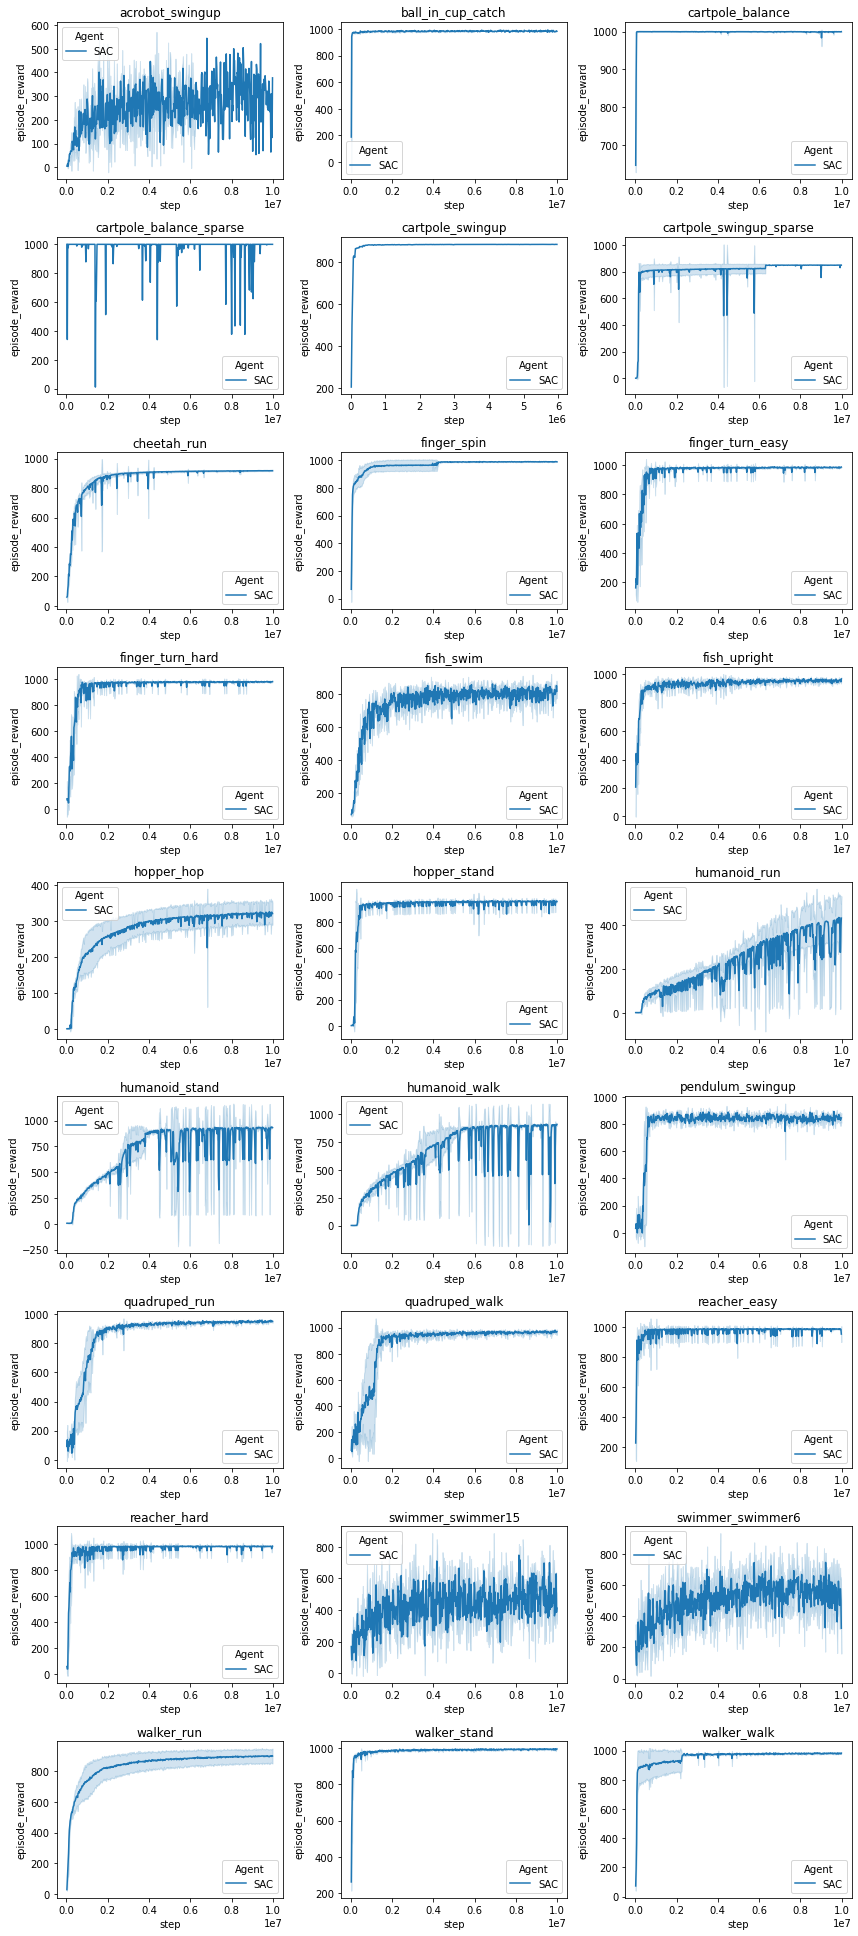

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot(df, base=None, key='episode_reward'):
    envs = np.sort(df.env.unique())
    ncol = 3
    assert envs.shape[0] % ncol == 0
    nrow = envs.shape[0] // ncol
    fig, axs = plt.subplots(nrow, ncol, figsize=(4 * ncol, 3 * nrow))
    #runs = sorted([str(x) for x in df.run.unique()])
    for idx, env in enumerate(envs):
        data = df[df['env'] == env]
        row = idx // ncol
        col = idx % ncol
        ax = axs[row, col]
        hue_order = np.sort(data.Agent.unique())
        #import ipdb; ipdb.set_trace()
        sns.lineplot(x='step', y=key, data=data, ci='sd', hue='Agent', hue_order=hue_order, ax=ax)
        #sns.lineplot(x=‘step’, y=key, data=data, ci=‘sd’, hue=‘run_id’, ax=ax, palette=sns.color_palette(‘Blues’)[3:4])
        if base is not None:
            if env in base:
                val = base[env]['d4pg']
                ax.axhline(val, ls='--', color='black', label='D4PG ($10^8$ steps)')
                ax.legend()
        ax.set_title(f'{env}')
        #ax.set_xlim(0, 10000000)
        #ax.set_ylim(0.0, 1050.0)
        #ax.legend_.remove()
    plt.tight_layout()
    plt.show()
plot(pd.read_csv('results/sac.csv'))

In [69]:
sac_results = pd.read_csv('results/sac.csv')

In [78]:
sac_results[sac_results.env == 'cartpole_swingup_sparse']

,Unnamed: 0,episode,episode_reward,step,run_id,agent,env,seed,experiment,log_save_tb,eval_frequency,num_train_steps,Agent
0,0,20.0,0.0,20000,run=17,sac,cartpole_swingup_sparse,3,bench,False,20000,10000000.0,SAC
1,1,40.0,0.0,40000,run=17,sac,cartpole_swingup_sparse,3,bench,False,20000,10000000.0,SAC
2,2,60.0,2.4,60000,run=17,sac,cartpole_swingup_sparse,3,bench,False,20000,10000000.0,SAC
3,3,80.0,2.6,80000,run=17,sac,cartpole_swingup_sparse,3,bench,False,20000,10000000.0,SAC
4,4,100.0,0.0,100000,run=17,sac,cartpole_swingup_sparse,3,bench,False,20000,10000000.0,SAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34776,310,6220.0,798.9,6220000,run=16,sac,cartpole_swingup_sparse,2,bench,False,20000,10000000.0,SAC
34777,311,6240.0,798.0,6240000,run=16,sac,cartpole_swingup_sparse,2,bench,False,20000,10000000.0,SAC
34778,312,6260.0,796.1,6260000,run=16,sac,cartpole_swingup_sparse,2,bench,False,20000,10000000.0,SAC
34779,313,6280.0,798.5,6280000,run=16,sac,cartpole_swingup_sparse,2,bench,False,20000,10000000.0,SAC


In [80]:
sac_results[sac_results.env == 'cartpole_swingup_sparse']['seed'].reset_index(drop=True)

array([3, 2])

In [81]:
np.array(sac_results[sac_results.env == 'cartpole_swingup_sparse']['seed'])

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,